Tune learning rate (-r) and regularization strength (-b).
Do randomized grid search.

In [112]:
import numpy as np
import os
import re
import subprocess

## Results

- `train_site_small`: learning_rate (1e-3, 1e1), reg_param (1e-2, 1e1)
    Try (lr, reg) = (1.5055668655636434, 0.14551999446480063)
- `train_app_small`: (0.00166189386987065, 0.48305136367563084)

In [113]:
def parse_best_loss(run_result):
    lines = run_result.stdout.decode().split('\n')
    best_loss_line = [l for l in lines if 'best loss' in l]
    if best_loss_line:
        best_loss_line = best_loss_line[0]
        best_loss = re.search(r'best loss: (\d+.\d+)', best_loss_line).group(1)
        return float(best_loss)
    else:
        # No line matches 'best loss' if early stopping wasn't necessary.
        # Given the fact that FFM is very likely to overfit, this result
        # is most likely not of our interest.
        return np.nan

def eval_param(train_set, validation_set, learning_rate=0.2, reg_param=1e-5):
    xlearn_train = '~/code/xlearn/build/xlearn_train'
    command = [xlearn_train, train_set,
          '-s 2',
         '-v', validation_set,
          '-r', str(learning_rate),
               '-b', str(reg_param)]
    command = ' '.join(command)
    result = subprocess.run(command, stdout=subprocess.PIPE, shell=True)
    return parse_best_loss(result)

def log_uniform(low=0, high=1, size=None):
    return np.power(10, np.random.uniform(low, high, size))

def eval_param_ls(train_set, validation_set, learning_rates, reg_params):
    scores = [eval_param(train_set, validation_set, lr, reg)
              for lr, reg in zip(learning_rates, reg_params)]
    
    minidx = np.nanargmin(np.array(scores))
    min_score = scores[minidx]
    best_lr = learning_rates[minidx]
    best_reg = reg_params[minidx]
    return min_score, best_lr, best_reg, scores

In [135]:
size=100
learning_rates = log_uniform(-2,1,size) # default = 0.2
reg_params = log_uniform(-6,3,size) # default = 1e-5

In [144]:
project_path = '~/code/avazu-ctr/'
xlearn_train = '~/code/xlearn/build/xlearn_train'
train_set = os.path.join(project_path, 'ffm-data/train_app_small.ffm')
validation_set = os.path.join(project_path, 'ffm-data/validate_app_small.ffm')

In [145]:
%%time
best_score, best_lr, best_reg, scores = eval_param_ls(train_set, validation_set, learning_rates, reg_params)

CPU times: user 72.6 ms, sys: 545 ms, total: 617 ms
Wall time: 6min 43s


In [125]:
scores

[nan, 0.458593, nan, 0.477638, nan, nan, 0.496982, nan, nan, nan]

In [124]:
max_score

0.374588

In [148]:
# find a score for a parameter pair that didn't overfit.
best_score = min([s for s in scores if s > 0.30])
best_idx = scores.index(best_score)
learning_rates[best_idx], reg_params[best_idx]

(0.4327129488305789, 0.00010430676322542866)

(0.00166189386987065, 0.48305136367563084)

In [68]:
max_score, best_lr, best_reg

(0.073864, 5.8180412773539905, 0.15273521840224266)

In [58]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

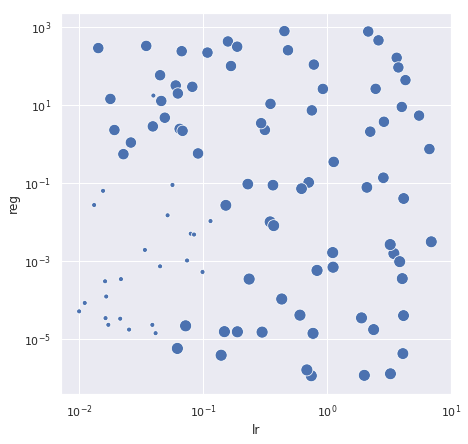

In [147]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log", xlabel='lr', ylabel='reg')
points = [0.5 if s is np.nan or s > 1 else 1/s for s in scores]
sns.scatterplot(learning_rates, reg_params, s=[50*p for p in points])

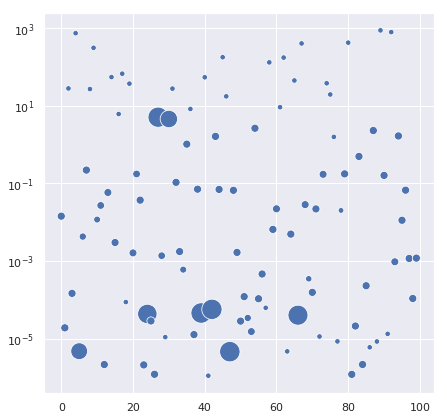

In [88]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
points = [1 if s is np.nan or s > 1 else 1/s for s in scores]
sns.scatterplot(range(size), learning_rates, s = [30*p for p in points])